# Projet INF8225
## Apprentissage par transfert

*Juliette Gerbaux et Katia Jodogne-del Litto*

## Importations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 #OpenCV documentation : https://docs.opencv.org/4.x/
import matplotlib.patches as patches
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import time
import glob
!pip install wandb > /dev/null
import wandb
from collections import defaultdict
!pip install einops > /dev/null
import einops

import seaborn as sns
sns.set_theme()

## Preprocessing

### Flowers dataset

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2022-04-29 23:00:56--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2022-04-29 23:00:56 ERROR 500: Internal Server Error.

--2022-04-29 23:00:56--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2022-04-29 23:00:57 ERROR 500: Internal Server Error.

--2022-04-29 23:00:57--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting re

In [3]:
import scipy.io
mat = scipy.io.loadmat('imagelabels.mat')
flower_labels = mat.get('labels')
size = len(flower_labels[0])
print(size)

FileNotFoundError: ignored

In [ ]:
import scipy.io
mat = scipy.io.loadmat('setid.mat')
train = mat.get('trnid')
valid = mat.get('valid')
test = mat.get('tstid')
print("train: ", len(train[0]))
print("valid: ", len(valid[0]))
print("test: ", len(test[0]))

In [ ]:
!tar -xvf /content/102flowers.tgz 

In [ ]:
ex = cv2.imread('jpg/image_00435.jpg')
print(flower_labels[0][435])
ex = cv2.cvtColor(ex, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1)
ax.imshow(ex)
plt.axis('off')
plt.show()

In [ ]:
class FlowerDataset(torch.utils.data.dataset.Dataset):
    def __init__(
            self,
            datasetid,
            preprocess,
            labels
        ):
        super().__init__()

        self.datasetid = datasetid
        self.preprocess = preprocess
        self.labels = labels

    def __len__(self):
        """Return the number of examples in the dataset.
        """
        return len(self.datasetid)

    def __getitem__(self, index: int) -> tuple:
        """Return a sample.

        Args
        ----
            index: Index of the sample.

        Output
        ------
            input_tensor : tensor
            label : int
        """
        idx_image = '0000'+str(self.datasetid[index])
        input_image = Image.open('jpg/image_'+idx_image[-5:]+'.jpg')
        label = self.labels[self.datasetid[index]]-1
        input_tensor = self.preprocess(input_image)
        return input_tensor, label

### Naturalist dataset

In [4]:
from google.colab import drive

drive.mount('/content/drive')
root_path = 'drive/MyDrive/Fungi' 

Mounted at /content/drive


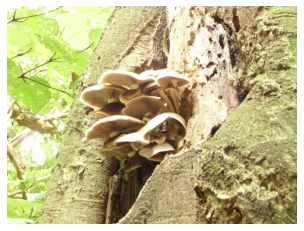

In [5]:
ex = cv2.imread(root_path+'/Agrocybe parasitica/028ec1c88701ec38291810cba41df7aa.jpg')
ex = cv2.cvtColor(ex, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1)
ax.imshow(ex)
plt.axis('off')
plt.show()

In [6]:
import os
categories_dic = {}
categories_list = []
images = []
fungi_labels = []
i = 0
for directory in os.listdir(root_path):
  categories_dic[directory] = i
  categories_list.append(directory)

  for filename in glob.glob(root_path + '/' + directory + "/*.jpg"):
    #print(filename)
    images.append(filename.split('/')[-1].split('.')[0])
    fungi_labels.append(i)

  i+=1

In [7]:
print(len(categories_list))

121


In [8]:
# import pandas as pd
# truc = pd.Dataset
np.bincount(fungi_labels).min()

15

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

#sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=42)

#for train_index, test_index in sss.split(images, fungi_labels):
#  fungi_train, fungi_test = np.asarray(images)[train_index], np.asarray(images)[test_index]
#  y_fungi_train, y_fungi_test =  np.asarray(fungi_labels)[train_index], np.asarray(fungi_labels)[test_index]


fungi_train, fungi_valid, y_fungi_train, y_fungi_valid = train_test_split(images, fungi_labels, train_size=0.8)
#fungi_valid, fungi_test, y_fungi_valid, y_fungi_test = train_test_split(fungi_test, y_fungi_test, train_size=1020)
print(len(fungi_train))
print(fungi_train)

6104
['3578641d0ccc4ad99d85270ff74c4472', '25f6627b9758b696e66f72537c66df3f', 'cf109f72e12b670e305ba22930946b26', '3874264e0c5b900809cb3bdf3498f50f', '12dcf43019964902849751ac3d903abb', '11b9791170bfbabdde291b4849c6b02d', 'f3db5782ca07dd94e4bc39dafd873f9c (1)', '0363ae81065eedcce270115ec85153ae', '93c59feddd38bd00e571468558a97ebb', 'b2e82f9698cd248accb1ea106e63eb83', 'e26298f8bae468b8aedda1bc70241bf1', '900812510badb8207bda2ba6ec040922', '0ab72c52c54547551d121a4b0d407688', '3c7d0e4f4a04b5ae289cf3745a5ecece', '603ea977d79db8f2dc110488c8261f4f', '24737a20ff5d15f257c9f3bf2d9abd06', '0f84338be6421092daaf7e37264a3c40', '126c47a1f8bf820434da010f91fb1008', 'bddc6fe8a09448e3fe2059ed9daee161', '2f2a938c46437778a9559e5542ee9455', '37b4592b3d9cc730265677e77f8ddbb9', '13c4178c794ca278e8b531f3a867a506', 'd77e705804e77d6c826d482a0bd9734f', 'a9707ab61fa6fd2988b6ad0358e76a1b', '4972ae0d8d222eb8c5901cd2cf175867', '9ca8da5c51a2733b05fd395da7bb7cb2', 'dd33d18035b99929692cf828317960e9', '63b1acb0ab6816402

In [10]:
print(np.unique(y_fungi_train))
print(len(np.unique(fungi_labels)))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120]
121


['3578641d0ccc4ad99d85270ff74c4472', '25f6627b9758b696e66f72537c66df3f', 'cf109f72e12b670e305ba22930946b26', '3874264e0c5b900809cb3bdf3498f50f', '12dcf43019964902849751ac3d903abb', '11b9791170bfbabdde291b4849c6b02d', 'f3db5782ca07dd94e4bc39dafd873f9c (1)', '0363ae81065eedcce270115ec85153ae', '93c59feddd38bd00e571468558a97ebb', 'b2e82f9698cd248accb1ea106e63eb83', 'e26298f8bae468b8aedda1bc70241bf1', '900812510badb8207bda2ba6ec040922', '0ab72c52c54547551d121a4b0d407688', '3c7d0e4f4a04b5ae289cf3745a5ecece', '603ea977d79db8f2dc110488c8261f4f', '24737a20ff5d15f257c9f3bf2d9abd06', '0f84338be6421092daaf7e37264a3c40', '126c47a1f8bf820434da010f91fb1008', 'bddc6fe8a09448e3fe2059ed9daee161', '2f2a938c46437778a9559e5542ee9455', '37b4592b3d9cc730265677e77f8ddbb9', '13c4178c794ca278e8b531f3a867a506', 'd77e705804e77d6c826d482a0bd9734f', 'a9707ab61fa6fd2988b6ad0358e76a1b', '4972ae0d8d222eb8c5901cd2cf175867', '9ca8da5c51a2733b05fd395da7bb7cb2', 'dd33d18035b99929692cf828317960e9', '63b1acb0ab6816402b9b55

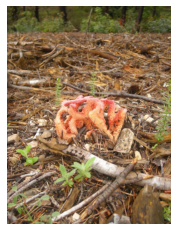

In [11]:
print(fungi_train)
print(len(fungi_train))
print(y_fungi_train)
print(len(y_fungi_train))

label = y_fungi_train[0]

print(categories_list[label])

ex = cv2.imread(root_path+'/' +categories_list[label] +'/' + fungi_train[0] +'.jpg')
ex = cv2.cvtColor(ex, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1)
ax.imshow(ex)
plt.axis('off')
plt.show()

In [12]:
class iNaturalistDataset(torch.utils.data.dataset.Dataset):
    def __init__(
            self,
            filenames,
            preprocess,
            labels,
            categories_list = None
        ):
        super().__init__()

        self.filenames = filenames
        self.preprocess = preprocess
        self.labels = labels

        self.categories_list = categories_list

    def __len__(self):
        """Return the number of examples in the dataset.
        """
        return len(self.filenames)

    def __getitem__(self, index: int) -> tuple:
        """Return a sample.

        Args
        ----
            index: Index of the sample.

        Output
        ------
            input_tensor : tensor
            label : int
        """
        #print("index ", index)
        idx_image = self.filenames[index]
        #print(idx_image)
        label = self.labels[index]
        #print(self.categories_list[label])
        input_image = Image.open(root_path + '/' + self.categories_list[label] + '/' +idx_image +'.jpg')
        input_tensor = self.preprocess(input_image)
        return input_tensor, label

## Architecture

### Training loop

In [13]:
def print_logs(dataset_type: str, logs: dict):
    """Print the logs.

    Args
    ----
        dataset_type: Either "Train", "Eval", "Test" type.
        logs: Containing the metric's name and value.
    """
    desc = [
        f'{name}: {value:.2f}'
        for name, value in logs.items()
    ]
    desc = '\t'.join(desc)
    desc = f'{dataset_type} -\t' + desc
    desc = desc.expandtabs(5)
    print(desc)


def loss_batch(
        model,
        image,
        label,
        config,
    )-> dict:
    """Compute the metrics associated with this batch.
    The metrics are:
        - loss
        - top-1 accuracy
        - top-5 accuracy

    Output
    ------
        metrics: Dictionnary containing evaluated metrics on this batch.
    """
    device = config['device']
    loss_fn = config['loss'].to(device)
    metrics = dict()

    image, label = image.to(device), label.to(device)

    # Loss
    pred = model(image) 
    try :
      pred = pred.to(device)
    except AttributeError:
      pred = pred.logits.to(device)
    
    metrics['loss'] = loss_fn(pred, label)

    # Accuracy 
    for k in [1, 5, 10]:
        total = image.shape[0]

        _, pred_k = pred.topk(k=k, dim=-1)

        real_labels = einops.repeat(label, 'b -> b k', k=k)  

        good = (pred_k == real_labels)
        acc = good.sum() / total
        
        metrics[f'top-{k}'] = acc

    return metrics


def eval_model(model, dataloader, config) -> dict:
    """Evaluate the model on the given dataloader.
    """
    device = config['device']
    logs = defaultdict(list)

    model.to(device)

    with torch.no_grad():
        for image, label in dataloader:
            metrics = loss_batch(model, image, label, config)
            for name, value in metrics.items():
                logs[name].append(value.cpu().item())

    for name, values in logs.items():
        logs[name] = np.mean(values)
    return logs


def train_model(model: nn.Module, config: dict):
    train_loader, val_loader = config['train_loader'], config['val_loader']
    optimizer = config['optimizer']
    device = config['device']

    # Early stopping
    last_loss = 100
    patience = config['patience']
    triggertimes = 0
    
    model = model.to(device)

    # Freezing of layers
    for (name, module) in model.named_children():
        for param in module.parameters():
            if name in config['freeze'] :
                param.requires_grad = False
            else :
                param.requires_grad = True

    print(f'Starting training for {config["epochs"]} epochs, using {device}.')
    for e in range(config['epochs']):
        print(f'\nEpoch {e+1}')
        debut = time.time()
        model.train(True)      
        logs = defaultdict(list)

        running_loss = 0
        for batch_id, (source, label) in enumerate(train_loader):
            optimizer.zero_grad()

            metrics = loss_batch(model, source, label, config)
            loss = metrics['loss']
            loss.backward()
            running_loss += loss

            optimizer.step()

            for name, value in metrics.items():
                logs[name].append(value.cpu().item())  # Don't forget the '.item' to free the cuda memory
            if batch_id % config['log_every'] == 0:
                for name, value in logs.items():
                    logs[name] = np.mean(value)

                train_logs = {
                    f'Train - {m}': v
                    for m, v in logs.items()
                }
                wandb.log(train_logs)
                logs = defaultdict(list)

        # We don't need gradients on to do reporting
        model.train(False)

        # Logs
        if len(logs) != 0:
            for name, value in logs.items():
                logs[name] = np.mean(value)
            train_logs = {
                f'Train - {m}': v
                for m, v in logs.items()
            }
        else:
            logs = {
                m.split(' - ')[1]: v
                for m, v in train_logs.items()
            if ' - ' in m}

        print_logs('Train', logs)

        logs = eval_model(model, val_loader, config)
        print_logs('Eval', logs)
        val_logs = {
            f'Validation - {m}': v
            for m, v in logs.items()
        }

        logs = {**train_logs, **val_logs}  # Merge dictionnaries
        wandb.log(logs)  # Upload to the WandB cloud

        duree = time.time()-debut
        print(f'Durée : {duree} secondes')

        # Early stopping
        current_loss = logs['Validation - loss']

        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')

                return model

        else:
            print('Trigger Times: 0')
            trigger_times = 0

            last_loss = current_loss


### ResNet

In [14]:
# pretrained_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# pretrained_resnet.eval()

In [15]:
# pretrained_resnet._modules['fc'] = nn.Linear(in_features=512, out_features=102, bias=True)
# pretrained_resnet.eval()

In [16]:
#Data augmentation
resnet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

resnet_transform_valid = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [17]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet._modules['fc'] = nn.Linear(in_features=512, out_features=102, bias=True)
resnet.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
for name, param in resnet.named_parameters():
    print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [19]:
for (name, module) in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


### Inception

In [20]:
# pretrained_inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
# pretrained_inception.eval()

In [21]:
# pretrained_inception._modules['fc'] = nn.Linear(in_features=2048, out_features=102, bias=True)
# pretrained_inception.eval()

In [22]:
inception_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

inception_transform_valid = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=False, aux_logits=False)
inception._modules['fc'] = nn.Linear(in_features=2048, out_features=102, bias=True)
inception.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [24]:
for name, module in inception.named_children():
  print(name)

Conv2d_1a_3x3
Conv2d_2a_3x3
Conv2d_2b_3x3
maxpool1
Conv2d_3b_1x1
Conv2d_4a_3x3
maxpool2
Mixed_5b
Mixed_5c
Mixed_5d
Mixed_6a
Mixed_6b
Mixed_6c
Mixed_6d
Mixed_6e
Mixed_7a
Mixed_7b
Mixed_7c
avgpool
dropout
fc


In [25]:
for name, param in inception.named_parameters():
  print(name)

Conv2d_1a_3x3.conv.weight
Conv2d_1a_3x3.bn.weight
Conv2d_1a_3x3.bn.bias
Conv2d_2a_3x3.conv.weight
Conv2d_2a_3x3.bn.weight
Conv2d_2a_3x3.bn.bias
Conv2d_2b_3x3.conv.weight
Conv2d_2b_3x3.bn.weight
Conv2d_2b_3x3.bn.bias
Conv2d_3b_1x1.conv.weight
Conv2d_3b_1x1.bn.weight
Conv2d_3b_1x1.bn.bias
Conv2d_4a_3x3.conv.weight
Conv2d_4a_3x3.bn.weight
Conv2d_4a_3x3.bn.bias
Mixed_5b.branch1x1.conv.weight
Mixed_5b.branch1x1.bn.weight
Mixed_5b.branch1x1.bn.bias
Mixed_5b.branch5x5_1.conv.weight
Mixed_5b.branch5x5_1.bn.weight
Mixed_5b.branch5x5_1.bn.bias
Mixed_5b.branch5x5_2.conv.weight
Mixed_5b.branch5x5_2.bn.weight
Mixed_5b.branch5x5_2.bn.bias
Mixed_5b.branch3x3dbl_1.conv.weight
Mixed_5b.branch3x3dbl_1.bn.weight
Mixed_5b.branch3x3dbl_1.bn.bias
Mixed_5b.branch3x3dbl_2.conv.weight
Mixed_5b.branch3x3dbl_2.bn.weight
Mixed_5b.branch3x3dbl_2.bn.bias
Mixed_5b.branch3x3dbl_3.conv.weight
Mixed_5b.branch3x3dbl_3.bn.weight
Mixed_5b.branch3x3dbl_3.bn.bias
Mixed_5b.branch_pool.conv.weight
Mixed_5b.branch_pool.bn.weig

### Training

In [26]:
#!wandb offline
!wandb login

!nvidia-smi

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Fri Apr 29 23:02:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|           

In [27]:
config = {
    # General parameters
    'epochs': 20,
    'batch_size': 20,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    'log_every': 5,  # Number of batches between each wandb logs
    'patience' : 5,  # Patience for early stopping mechanism
}


config['pretrained'] = True

config['data_augmentation'] = True

model_type = inception

config['freeze'] = []

if model_type == resnet:
  config['valid_preprocess'] = resnet_transform_valid
  if config['data_augmentation']:
    config['preprocess'] = resnet_transform
  else : 
    config['preprocess'] = resnet_transform
elif model_type == inception:
  config['valid_preprocess'] = inception_transform_valid
  if config['data_augmentation']:
    config['preprocess'] = inception_transform
  else : 
    config['preprocess'] = inception_transform

"""

config['train_loader'] = torch.utils.data.DataLoader(FlowerDataset(train[0],config['preprocess'],flower_labels[0]), 
                                                     batch_size=config['batch_size'], shuffle=True)

config['val_loader'] = torch.utils.data.DataLoader(FlowerDataset(valid[0],config['preprocess'],flower_labels[0]), 
                                                     batch_size=config['batch_size'], shuffle=True)

config['dataset'] = 'flower'

config['nb_classes'] = 102

"""

config['train_loader'] = torch.utils.data.DataLoader(iNaturalistDataset(fungi_train,config['preprocess'],y_fungi_train,categories_list), 
                                                     batch_size=config['batch_size'], shuffle=True)

config['val_loader'] = torch.utils.data.DataLoader(iNaturalistDataset(fungi_valid,config['valid_preprocess'],y_fungi_valid,categories_list), 
                                                     batch_size=config['batch_size'], shuffle=True)

config['dataset'] = 'fungi'

config['nb_classes'] = 121



if model_type == resnet:
  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=config['pretrained'])
  model._modules['fc'] = nn.Linear(in_features=512, out_features=config['nb_classes'], bias=True) 
elif model_type == inception:
  model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=config['pretrained'],aux_logits=False,transform_input=False)
  model._modules['fc'] = nn.Linear(in_features=2048, out_features=config['nb_classes'], bias=True)

config['optimizer'] = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    betas=(0.9, 0.99),
)

config['loss'] = torch.nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
#!wandb offline
with wandb.init(
        config=config,
        project='INF8225 - projet',  # Title of your project
        group='pretrained - inception',  # In what group of runs do you want this run to be in?
        save_code=True,
        entity="katia_juliette"
    ):
    train_model(model, config)

wandb: Currently logged in as: kjdl (use `wandb login --relogin` to force relogin)


Starting training for 20 epochs, using cuda.

Epoch 1
